<center><h1>多项式插值与三次样条插值<h1/><center/>

## 实验内容

在区间$[-1,1]$上分别取$n=6,10$用两组等距节点对$Runge$函数函数$f(x)=\frac1{1+25x^2}$作多项式插值和三次样条插值，对于每个$n$值分别画出插值函数及$f(x)$的图形

## 实验原理

### Lagrange 插值

#### Lagrange 插值基函数

$$
l_k(x)=\frac{(x-x_0)\cdots(x-x_{k-1})(x-x_{k+1})\cdots(x-x_n)}{(x_k-x_0)\cdots(x_k-x_{k-1})(x_k-x_{k+1})\cdots(x_k-x_n)}\quad k=0,1,\cdots,n.
$$

其满足
$$
l_j(x_k)=\delta_{jk}=
\begin{cases}
1,&k=j\\
0,&k\neq j
\end{cases}
\quad j,k=0,1,\cdots,n
$$

#### Lagrange 插值多项式

$$
L_n(x)=\sum_{k=0}^ny_kl_k(x)
$$

### 三次样条插值

设$S(x)$在每一个区间上是三次多项式，故$S''(x)$是线性函数，可表示为
$$
S''(x)=M_j\frac{x_{j+1}-x}{h_j}+M_{j+1}\frac{x-x_j}{h_j}
$$
积分两次，代入$S(x_j)=y_j,S(x_{j+1})=y_{j+1}$,得到三次样条表达式
$$
S(x)=M_j\frac{(x_{j+1}-x)^3}{6h_j}+M_{j+1}\frac{(x-x_j)^3}{6h_j}+\left(y_j-\frac{M_jh_j^2}6\right)\frac{x_{j+1}-x}{h_j}+\left(y_{j+1}-\frac{M_{j+1}h_j^2}6\right)\frac{x-x_j}{h_j}
$$
求导得到$S'(x)$

利用$S'(x_j+0)=S'(x_j-0)$可得
$$
\mu_jM_{j-1}+2M_j+\lambda_jM_{j+1}=d_j\qquad j=1,2,\cdots,n-1
$$
其中
$$
\mu_j=\frac{h_{j-1}}{h_{j-1}+h_j},\lambda_j=\frac{h_j}{h_{j-1}+h_j},
$$

$$
d_j=6f[x_{j-1},x_j,x_{j+1}]\qquad j=1,2,\cdots,n-1
$$

对该问题，这里选用`自然边界条件`，即
$$
S''(x_0)=S''(x_n)=0
$$
此时，令
$$
\lambda_0=\mu_n=0,d_0=d_n=0
$$
矩阵形式：

$$
\begin{pmatrix}
2&\lambda_0\\
\mu_1&2&\lambda_1\\
&\ddots&\ddots&\ddots\\
&&\mu_{n-1}&2&\lambda_{n-1}\\
&&&\lambda_n&2\\
\end{pmatrix}
\begin{pmatrix}
M_0\\M_1\\\vdots \\M_{n-1}\\M_n
\end{pmatrix}
=
\begin{pmatrix}
d_0\\d_1\\\vdots \\d_{n-1}\\d_n
\end{pmatrix}
$$

解出$M_i$即得样条插值函数

## 编程实现
> 用Julia语言实现

先导入依赖

In [1]:
import Logging
Logging.disable_logging(Logging.Info)
using Polynomials,LinearAlgebra,Plots,LambdaFn
plotly();

自定分段多项式类型，为三次样条插值实现作准备

In [2]:
struct PiecewisePolynomial
    piece::Vector{Real}
    polynomials::Vector{Polynomial}
    n::Integer
end

function PiecewisePolynomial(piece, polynomials)
    n₊ = length(piece)
    n = length(polynomials)
    @assert n₊ == n+1 
    return PiecewisePolynomial(piece, polynomials,n) 
end

function (pp::PiecewisePolynomial)(x)
    for i = 1:pp.n
        if x ≤ pp.piece[i+1]
            return pp.polynomials[i](x)
        end
    end
end

### 多项式插值

这里使用$Lagrange$插值方法

In [3]:
function LagrangeBaseFunc(x::Vector,xₖ::Real)::Polynomial
    lₖ = (fromroots∘filter)(xᵢ->xᵢ≠xₖ,x)
    lₖ / lₖ(xₖ)
end

function Lagrange(x::Vector,y::Vector)::Polynomial
    bases = @λ(LagrangeBaseFunc(x,_)).(x)
    return sum(bases.*y)
end;

### 三次样条插值

In [4]:
function Spline³(x::Vector,y::Vector;λ₁=0,μₙ=0,d₁=0,dₙ=0)
    n = length(x)
    h = x[2:n].-x[1:n-1]
    sh = h[1:n-2].+h[2:n-1]
    λ = [λ₁;h[2:n-1]./sh]
    μ = [h[1:n-2]./sh;μₙ]
    d(i) = 6((y[i+1]-y[i])/h[i]-(y[i]-y[i-1])/h[i-1])
    d = [d₁;d.(2:n-1)./sh;dₙ]
    M = Tridiagonal(μ,2ones(n),λ)\d
    S(j) = (M[j]*Polynomial([x[j+1],-1])^3/6
            + M[j+1]*Polynomial([-x[j],1])^3/6
            + (y[j]-M[j]*h[j]^2/6)*Polynomial([x[j+1],-1])
            + (y[j+1]-M[j+1]*h[j]^2/6)*Polynomial([-x[j],1]))
    S =  S.(1:n-1)./h
    S = PiecewisePolynomial(x,S)
end

Spline³ (generic function with 1 method)

## 计算实例、数据、结果

In [5]:
f(x) = 1/(1+25x^2);

In [6]:
function interpolate(method::Function,target::Function,interval::Vector,n::Integer)
    x = range(interval...;length=n+1) |> collect
    y = target.(x)
    return method(x,y)
end;

In [7]:
x = range(-1,1;length=300) |> collect
y = f.(x)

function experiment(;n,legend=true)
    L = interpolate(Lagrange,f,[-1,1],n)
    δL = abs.(y .- L.(x))

    S = interpolate(Spline³,f,[-1,1],n)
    δS = abs.(y .- S.(x))

    plot1 = plot(x,y,label="Runge Function",title="Function Plot(n=$n)")
    plot!(plot1,x,L.(x),label="Lagrange Interpolation")
    plot!(plot1,x,S.(x),label="Cubic Spline Interpolation")
    ylims!(plot1,-.2,1.5)

    plot2 = plot(x,zero(x),label="0",title="Error of Interpolation")
    plot!(plot2,x,δL,label="δL")
    plot!(plot2,x,δS,label="δS")
    
    plot(plot1,plot2,layout = (2, 1),legend=legend)  
end;

### 当n=6

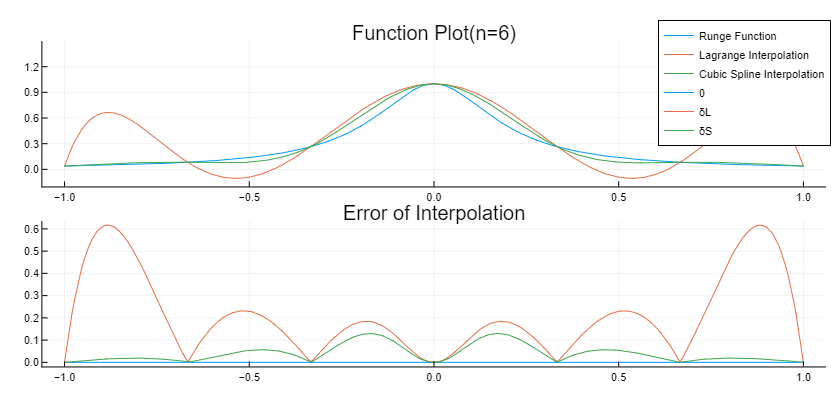

In [8]:
experiment(n=6)

### 当n=10

#### Lagrange 插值结果

In [9]:
L = interpolate(Lagrange,f,[-1,1],10)

Polynomial(1.0 - 1.2735580819100978e-15*x - 16.8552036199095*x^2 + 8.080428687273766e-14*x^3 + 123.35972850678719*x^4 - 4.416605969836951e-14*x^5 - 381.4338235294116*x^6 + 4.305444889496357e-13*x^7 + 494.9095022624427*x^8 - 9.156564395595979e-14*x^9 - 220.94174208144779*x^10)

#### 三次样条插值结果

In [10]:
S = interpolate(Spline³,f,[-1,1],10)

using DataFrames

table = Vector()

for i ∈ 1:S.n
    push!(table,(x=S.piece[i:i+1],poly=S.polynomials[i]))
end

DataFrame(table)

,x,poly
,Array…,Polynom…
1,"[-1.0, -0.8]",0.468313 + 1.11327*x + 1.02513*x^2 + 0.34171*x^3
2,"[-0.8, -0.6]",0.750706 + 2.17225*x + 2.34885*x^2 + 0.893259*x^3
3,"[-0.6, -0.4]",0.738422 + 2.11082*x + 2.24648*x^2 + 0.836385*x^3
4,"[-0.4, -0.2]",1.54302 + 8.14532*x + 17.3327*x^2 + 13.4083*x^3
5,"[-0.2, 0.0]",1.0 - 1.11022e-15*x - 23.3939*x^2 - 54.4694*x^3
6,"[0.0, 0.2]",1.0 + 8.32667e-16*x - 23.3939*x^2 + 54.4694*x^3
7,"[0.2, 0.4]",1.54302 - 8.14532*x + 17.3327*x^2 - 13.4083*x^3
8,"[0.4, 0.6]",0.738422 - 2.11082*x + 2.24648*x^2 - 0.836385*x^3
9,"[0.6, 0.8]",0.750706 - 2.17225*x + 2.34885*x^2 - 0.893259*x^3


#### 绘图比较

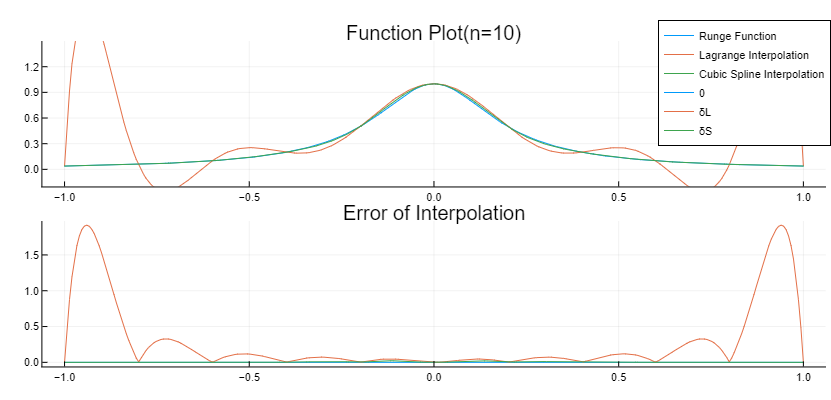

In [11]:
experiment(n=10)

## 结果分析
结果与理论相符，三次样条插值的误差小于普通多项式插值

## 参考文献
- [1] 李庆扬，王能超，易大义.数值分析[M].北京：清华大学出版社,2018.12
- [2] Julia.Docs:Linear Algebra[EB/OL].https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/
- [3] JuliaMath.Polynomials.jl[EB/OL].https://github.com/JuliaMath/Polynomials.jl

## 结尾

放个动画彩蛋，展示一下不同$n$情况下的拟合效果

Plots.AnimatedGif("C:\\Users\\CreatorFan\\Documents\\Course\\Numerial Analysis\\Julia\\tmp.gif")
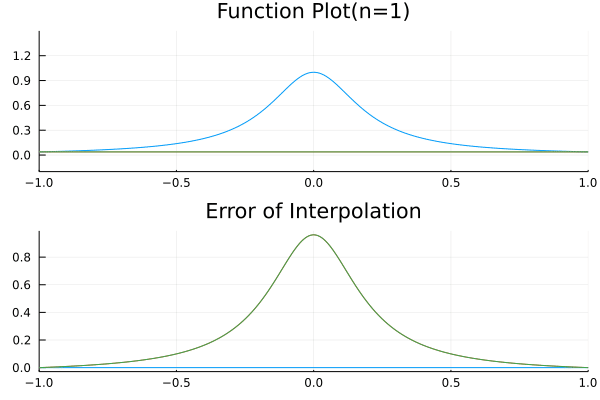

In [12]:
gr()
@gif for n ∈ 1:20
    experiment(n=n,legend=false)
    xlims!(-1,1)
end

## Copyright

> Copyright 2021 by Algebra-FUN(樊一飞)
>
> ALL RIGHTS RESERVED.